# EQ2425 Project 2

Names:
- Chunyu Wang
- Jingwen Liu

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import os
import sys
import re
import pickle
from scipy import ndimage
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
print("cv2.version == ", cv2.__version__)

cv2.version ==  3.4.2


In [2]:
# Initialize parameters
sift_pk_th = 0.12
sift_eg_th = 9

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000)

In [3]:
def folder_path_to_image_paths(folder_path):
    filenames = os.listdir(folder_path)
    image_names = [image for image in filenames if image.endswith('.JPG')]
    image_paths = [os.path.abspath(folder_path +'\\'+ img_name) for img_name in image_names]
    return image_paths

def read_in_img(image_paths):
    # image_paths is the path of the images inside server/client folder
    # return dimension: keypoints_num x 128
    index_to_des = {}
    index_to_FigureDigits = {}
    FigureDigits_to_index = {}
    total_des = 0

    for i in tqdm(range(len(image_paths)), file=sys.stdout, desc="desc"):
        img_path = image_paths[i]
        image = cv2.imread(img_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints_sift, descriptors_sift = sift.detectAndCompute(gray, None)

        # Indexing each figure with the read in order and its filename
        digits = re.findall(r'\d+', img_path)[-2:]
        index_to_FigureDigits[i] = (int(digits[0]), int(digits[1]))
        FigureDigits_to_index[(int(digits[0]), int(digits[1]))] = i
        
        index_to_des[i] = descriptors_sift
        total_des += len(keypoints_sift)
        
    print(f"Average descriptor number: {total_des/len(image_paths)}")
    return index_to_des, index_to_FigureDigits, FigureDigits_to_index


In [4]:
# Load the image.
client_path = os.path.abspath(os.getcwd() + '\\Data2\\client')
server_path = os.path.abspath(os.getcwd() + '\\Data2\\server')
client_filenames = os.listdir(client_path)
server_filenames = os.listdir(server_path)
client_image_paths = folder_path_to_image_paths(client_path)
server_image_paths = folder_path_to_image_paths(server_path)

In [5]:
server_file_path = 'server.json'
client_file_path = 'client.json'

# Save the dictionaries to the file
def save_dictionaries(file_path, *dictionaries):
    with open(file_path, 'wb') as f:
        pickle.dump(dictionaries, f)

# Load the dictionaries if the file exists
def load_dictionaries(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    else:
        return None

if os.path.exists(server_file_path):
    server_index_to_des, ItF_server, FtI_server = load_dictionaries(server_file_path)
    print("Read in server information successfully!")
else:
    server_index_to_des, ItF_server, FtI_server = read_in_img(server_image_paths)
    save_dictionaries(server_file_path, server_index_to_des, ItF_server, FtI_server)

if os.path.exists(client_file_path):
    client_index_to_des, ItF_client, FtI_client = load_dictionaries(client_file_path)
    print("Read in client information successfully!")
else:
    client_index_to_des, ItF_client, FtI_client = read_in_img(client_image_paths)
    save_dictionaries(client_file_path, client_index_to_des, ItF_client, FtI_client)

Read in server information successfully!
Read in client information successfully!


In [6]:
all_des = []

for each_des in server_index_to_des.values():
    for token in each_des:
        all_des.append(token)

print(np.shape(all_des))

(149036, 128)


In [7]:
class VocabularyTreeNode:
    def __init__(self, branch, depth):
        self.branch = branch  # Branch in the tree
        self.depth = depth  # Depth in the tree
        self.visual_words = []  # Clustering centers (visual words)
        self.children = []  # Child nodes
        self.des = None # descriptors

def hi_kmeans(descriptors, branch, current_depth, max_depth):
    """Recursively build the vocabulary tree."""
    if max_depth == 0 or len(descriptors) < branch or current_depth > max_depth:
        return None

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=branch)
    kmeans.fit(descriptors)

    # Create a new node for the current level
    node = VocabularyTreeNode(branch=branch, depth=current_depth)
    # print(f"Now at depth {current_depth}. Parent node construction complete.")
    
    # Split descriptors into clusters
    for cluster_idx in range(branch):
        # Get the descriptors that belong to this cluster
        cluster_descriptors = []
        for j in range(len(descriptors)):
            if kmeans.labels_[j] == cluster_idx:
                cluster_descriptors.append(descriptors[j])
        
        # Recursively build the next level of the tree
        child_node = hi_kmeans(cluster_descriptors, branch, current_depth+1, max_depth)
        # if child_node is None:
        #     print(f"Now at depth {current_depth}. Maximum depth reached! Node {cluster_idx}")
        # else:
        #     print(f"Now at depth {current_depth}. Child tree {cluster_idx} construction complete")
        
        if child_node is not None:
            if current_depth+1 == max_depth:
                child_node.des = cluster_descriptors
                child_node.visual_words = kmeans.cluster_centers_[cluster_idx]
            node.children.append(child_node)

    for child in node.children:
        if child.des is not None:
            node.visual_words.append(child.visual_words)
        else:
            for vw in child.visual_words:
                node.visual_words.append(vw)
    # print(f"Depth {current_depth} tree construction complete!")
    return node

In [11]:
def visual_words_of_leaf_nodes(tree:VocabularyTreeNode):
    if tree.des != None:
        return tree.visual_words
    
    all_visual_words = []
    for child in tree.children:
        vsws = visual_words_of_leaf_nodes(child)
        if len(vsws) != 128:
            for vsw in vsws:
                all_visual_words.append(vsw)
        else:
            all_visual_words.append(vsws)

    return all_visual_words

def Index_Database_Image(tree:VocabularyTreeNode, 
                         image_or_image_path, 
                         nfeatures_percentage=1,
                         server_index_to_des=None):
    # leafed_descriptors = visual_words_of_leaf_nodes(tree)
    leafed_descriptors = tree.visual_words
    leafed_des_num = len(leafed_descriptors)
    tf = np.zeros(leafed_des_num)
    tf_idf = []
    if server_index_to_des is None:
        # We are only dealing with a single image. Get its corresponding tf.
        image = cv2.imread(image_or_image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create(nfeatures = int(1000*nfeatures_percentage))
        _, descriptors_sift = sift.detectAndCompute(gray, None)
        for des in descriptors_sift:
            distances = pairwise_distances([des], leafed_descriptors, metric='l1')
            tf[np.argmin(distances)] += 1
        return tf
    else:
        K = len(server_index_to_des)
        tf_idf = np.zeros((leafed_des_num, K), dtype=float)
        f = np.zeros((leafed_des_num, K))
        for j in range(K):
            des_list = server_index_to_des[j]
            for des in des_list:
                distances = pairwise_distances([des], leafed_descriptors, metric='l1')
                f[np.argmin(distances)][j] += 1
        
        F = np.count_nonzero(f, axis=0)
        k_i = np.count_nonzero(f, axis=1)

        # Calculate the TF-IDF matrix
        for i in range(leafed_des_num):  # Loop over descriptors
            for j in range(K):  # Loop over images
                if F[j] != 0 and k_i[i] != 0:  # Avoid division by zero
                    tf_idf[i][j] = (f[i][j] / F[j]) * np.log2(K / k_i[i])
        
        return tf_idf

In [27]:
indexed_database_path = 'indexed_database.json'

if not os.path.exists(indexed_database_path):
    tree_43 = hi_kmeans(all_des, 4, 0, 3)
    tree_45 = hi_kmeans(all_des, 4, 0, 5)
    tree_57 = hi_kmeans(all_des, 5, 0, 7)

    indexed_database_43 = Index_Database_Image(tree_43, \
                                               server_image_paths, server_index_to_des)
    indexed_database_45 = Index_Database_Image(tree_45, \
                                               server_image_paths, server_index_to_des)
    indexed_database_57 = Index_Database_Image(tree_57, \
                                               server_image_paths, server_index_to_des)

In [23]:
if os.path.exists(indexed_database_path):
    indexed_database_43, indexed_database_45, indexed_database_57 \
        = load_dictionaries(indexed_database_path)
    print("Read in indexed database successfully!")

Read in indexed database successfully!


In [26]:
print(client_image_paths)

['c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj10_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj11_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj12_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj13_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj14_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj15_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj16_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj17_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj18_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj19_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj1_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\\proj\\2\\Data2\\client\\obj20_t1.JPG', 'c:\\Users\\27347\\Desktop\\KTH\\EQ2425\

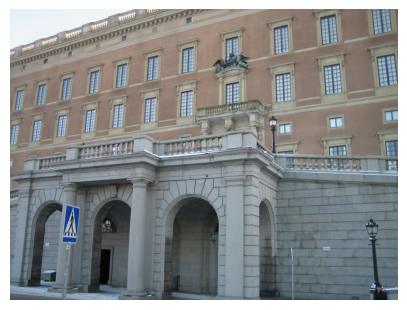

43: (22, 1); 45: (10, 3); 57: (10, 1)
43: (22, 2); 45: (10, 1); 57: (10, 3)
43: (22, 3); 45: (10, 2); 57: (10, 2)
43: (32, 1); 45: (23, 1); 57: (36, 2)
43: (49, 2); 45: (23, 2); 57: (36, 1)


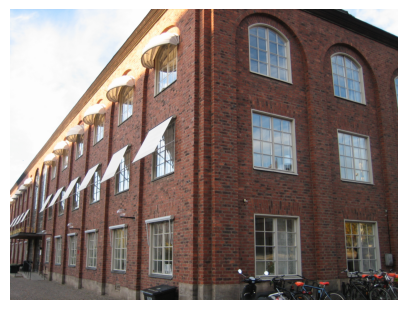

43: (28, 3); 45: (26, 1); 57: (11, 2)
43: (28, 2); 45: (8, 1); 57: (11, 3)
43: (28, 1); 45: (25, 1); 57: (8, 1)
43: (26, 1); 45: (8, 3); 57: (8, 2)
43: (23, 1); 45: (26, 2); 57: (11, 1)


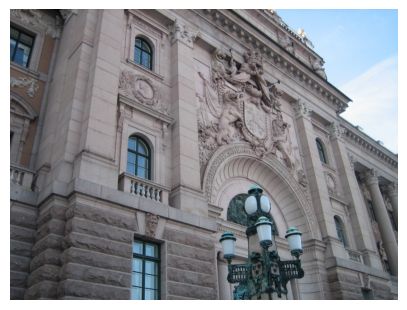

43: (28, 3); 45: (50, 1); 57: (28, 1)
43: (22, 1); 45: (50, 2); 57: (38, 2)
43: (28, 2); 45: (50, 3); 57: (47, 1)
43: (22, 2); 45: (45, 1); 57: (38, 1)
43: (49, 2); 45: (48, 2); 57: (47, 2)


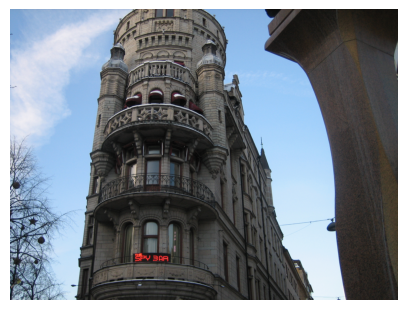

43: (28, 3); 45: (10, 3); 57: (13, 3)
43: (22, 1); 45: (10, 1); 57: (13, 2)
43: (28, 2); 45: (10, 2); 57: (38, 2)
43: (22, 2); 45: (13, 3); 57: (38, 1)
43: (49, 2); 45: (13, 2); 57: (13, 1)


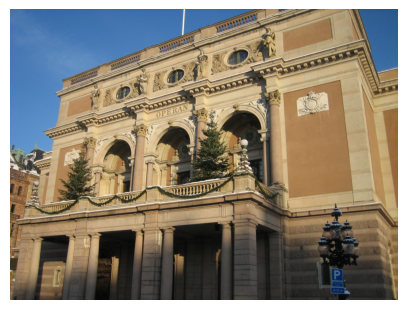

43: (22, 1); 45: (32, 2); 57: (36, 1)
43: (22, 2); 45: (32, 1); 57: (12, 3)
43: (22, 3); 45: (32, 3); 57: (12, 2)
43: (32, 1); 45: (15, 1); 57: (32, 2)
43: (49, 2); 45: (15, 3); 57: (13, 1)


In [32]:
def plot_image(image_path):
    # Print out the original figure.
    plt.figure(figsize=(5, 5))
    image_original_show = pltimg.imread(image_path)
    plt.imshow(image_original_show)
    plt.axis('off')
    plt.show()

for image_path in client_image_paths[0:5]:
    image_tf_43 = Index_Database_Image(tree_43, image_path)
    diff_43 = np.abs(indexed_database_43 - image_tf_43[:, None])
    image_tf_45 = Index_Database_Image(tree_45, image_path)
    diff_45 = np.abs(indexed_database_45 - image_tf_45[:, None])
    image_tf_57 = Index_Database_Image(tree_57, image_path)
    diff_57 = np.abs(indexed_database_57 - image_tf_57[:, None])

    column_sums_43 = np.sum(diff_43, axis=0)
    column_sums_45 = np.sum(diff_45, axis=0)
    column_sums_57 = np.sum(diff_57, axis=0)

    sorted_indices_43 = np.argsort(column_sums_43)
    sorted_indices_45 = np.argsort(column_sums_45)
    sorted_indices_57 = np.argsort(column_sums_57)

    plot_image(image_path)
    for i in range(0,5):
        idx_43 = sorted_indices_43[i]
        idx_45 = sorted_indices_45[i]
        idx_57 = sorted_indices_57[i]
        print(f"43: {ItF_server[idx_43]}; 45: {ItF_server[idx_45]}; 57: {ItF_server[idx_57]}")